In [1]:
import json
import os
import shutil

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sentinelhub
import shapely.geometry
from IPython.core.interactiveshell import InteractiveShell
from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    DataCollection,
    DownloadRequest,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

In [2]:
config = SHConfig()
# put here your config.sh_client_id and config.sh_client_secret
with open("/app/_data/config_params.json", "r") as f:
    config_params_gp = json.load(f)
config.sh_client_id = config_params_gp["SH_CLIENT_ID"]
config.sh_client_secret = config_params_gp["SH_CLIENT_SECRET"]
config.save()
%reload_ext autoreload
%autoreload 2

In [3]:
# model needs ["B02","B08","B11"] chanels
evalscript_3bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02","B08","B11"],
                units: "DN"
            }],
            output: {
                bands: 3,
                sampleType: "UINT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02,
                sample.B08,
                sample.B11];
    }
"""

In [4]:
# path to test area polygon
path = "/app/data/aoi_rayons.geojson"

In [5]:
test = gpd.read_file(path)
test

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,RUS,Russia,RUS.9_1,Buryat,Республика Бурятия,RUS.9.23_1,Yeravninskiy rayon,None,Еравнинский район,Raion,District,R60000,RU.BU.YE,"POLYGON ((113.01089 53.58788, 113.07199 53.577..."


### It's better to download tilles with intersection, that's why buffer is not zero

In [10]:
BUFFER = 0.05
RESOLUTION = 10
FOLDER_TO_SAVE = "/app/data/test_tiff/test_region/"
N_CHANELS = 3
UNIT_SIZE = 512 * 512 * 3
MAX_TILE_SIZE = 2500

In [11]:
# calculate size of all region
polygon = shape(test.loc[0, "geometry"]) # polygon of region
bbox_splitter = BBoxSplitter([polygon], CRS.WGS84, (1, 1))
bbox_list = bbox_splitter.get_bbox_list()
coords_wgs84 = bbox_list[0]
bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84).buffer(BUFFER)
tile_size = bbox_to_dimensions(bbox, resolution=RESOLUTION) # all region

h = tile_size[0] // MAX_TILE_SIZE + 1
w = tile_size[1] // MAX_TILE_SIZE + 1

# calculate size of one tile (not more than 2500x2500 pixels)

while tile_size[0] > MAX_TILE_SIZE - 50 or tile_size[1] > MAX_TILE_SIZE - 50:
    bbox_splitter = BBoxSplitter([polygon], CRS.WGS84, (h, w))
    bbox_list = bbox_splitter.get_bbox_list()
    coords_wgs84 = bbox_list[0]
    bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84).buffer(BUFFER)
    tile_size = bbox_to_dimensions(bbox, resolution=RESOLUTION)
    if tile_size[0] > 2500:
        h += 1
    if tile_size[1] > 2500:
        w += 1

units_per_region = np.round(
    len(bbox_list) * tile_size[0] * tile_size[1] * N_CHANELS / UNIT_SIZE, 1
)
print(
    f"Image shape at {RESOLUTION} m resolution: {tile_size} pixels, {units_per_region} units per region"
)

Image shape at 10 m resolution: (2397, 2372) pixels, 2841.3 units per region


In [12]:
total_area = len(bbox_list) * tile_size[0] * tile_size[1]
print(f" total area of region is {total_area} pixels")

 total area of region is 744824604 pixels


## request example

In [13]:
date = ["2021-05-31", "2021-07-31"]

In [14]:
request = SentinelHubRequest(
    data_folder=FOLDER_TO_SAVE,
    evalscript=evalscript_3bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=(date),
            mosaicking_order="leastCC",
            maxcc=0.5,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=tile_size,
    config=config,
)
all_bands_img = request.get_data(
    save_data=True,
)

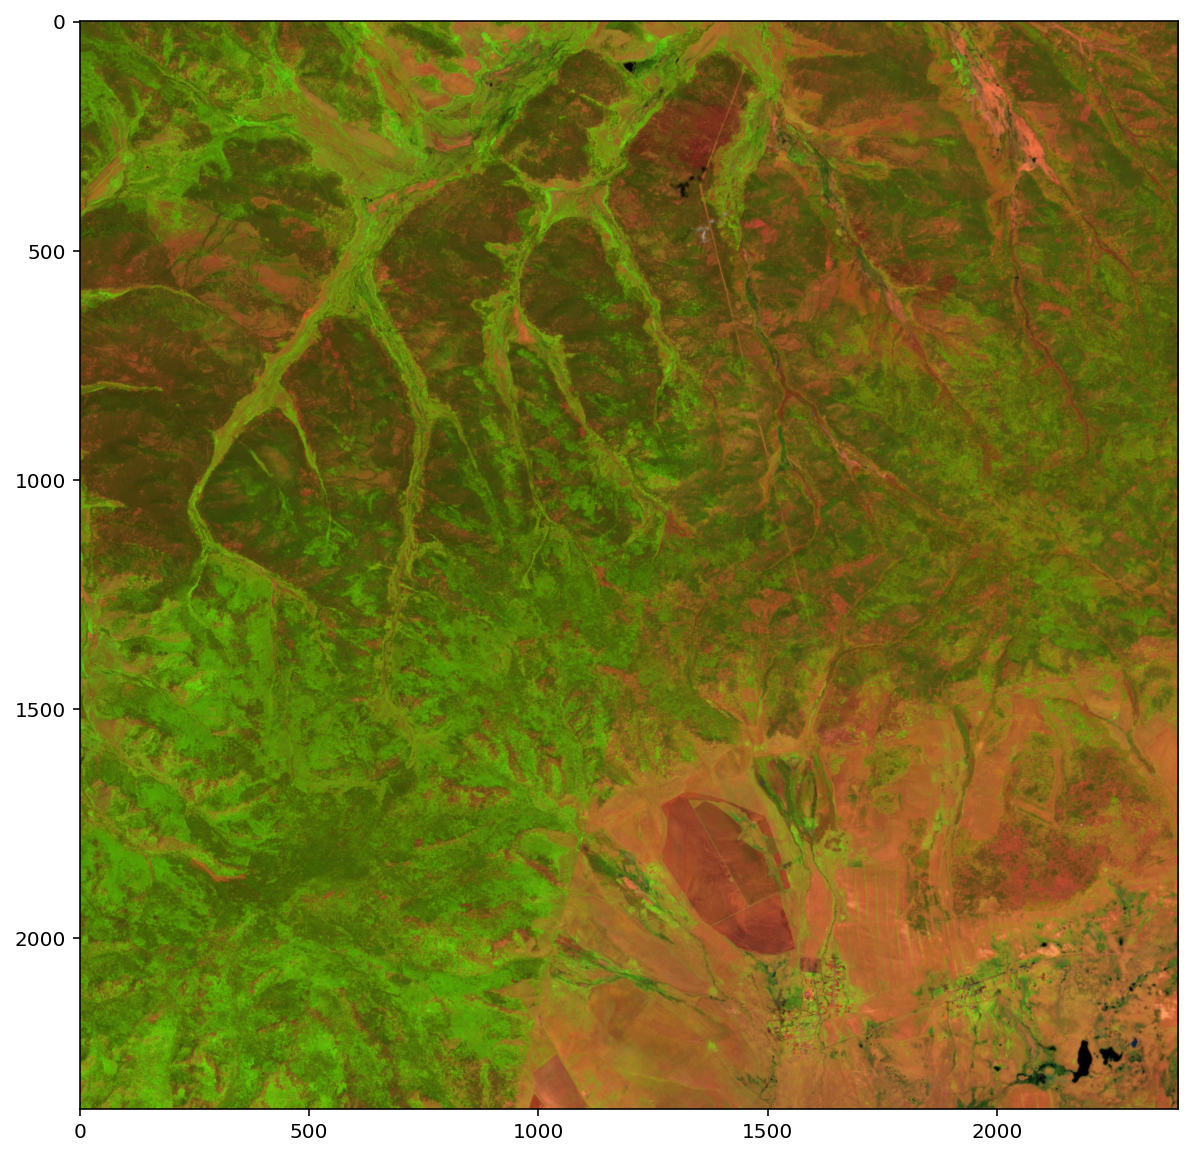

In [15]:
plt.figure(figsize=(10, 10))
all_bands_img1 = np.clip(all_bands_img[0], 0, 10000)
img = np.array(
    [
        (
            (all_bands_img1[:, :, i] - all_bands_img1[:, :, i].min())
            / (all_bands_img1[:, :, i].max() - all_bands_img1[:, :, i].min())
        )
        for i in [0, 1, 2]
    ]
)
plt.imshow(img.transpose(1, 2, 0))
plt.show();

## request example for all tiles of region

In [ ]:
for i in range(len(bbox_list)):
    coords_wgs84 = bbox_list[i]
    bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84).buffer(buffer)
    tile_size = bbox_to_dimensions(bbox, resolution=resolution)
    request = SentinelHubRequest(
        data_folder=folder_to_save,
        evalscript=evalscript_3bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(date),
                mosaicking_order="leastCC",
                maxcc=0.5,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=tile_size,
        config=config,
    )
all_bands_img = request.get_data(
    save_data=True,
)